![Assimila logo](../helpers/logosmall.png "Assimila")
# Assimila Prise Products
# Analyse Temperature Product

If the drop down menus do not appear restart the notebook by selecting "Kernel" then "Restart" above.

In [1]:
import os
import sys

sys.path.append('../')
from DQTools.DQTools import Dataset

sys.path.append('../helpers/')
from widgets import Widgets
from data import Data

import matplotlib

import matplotlib.cm as cm
import matplotlib.animation as animation

import matplotlib.cbook as cbook
import matplotlib.image as image

matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import gdal
import numpy as np
import xarray as xr

import ipywidgets as widgets
import pandas as pd
import datetime
import calendar

from IPython.display import clear_output
from IPython.display import display

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML('''<style>.widget-label { min-width: 20ex !important; }</style>'''))

%matplotlib notebook 

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def analyse_days(tmin, tmax):
    """
    Handle the min, mean and max for DAILY timestep.
    
    :returns: DataArrays for single day [tmin, tmax]
    """
    mean_min = t2m_data.sel(time=slice(tmin, tmax)).min('time')
    mean_mean = t2m_data.sel(time=slice(tmin, tmax)).mean('time')
    mean_max = t2m_data.sel(time=slice(tmin, tmax)).max('time')

    return mean_min, mean_mean, mean_max

def analyse_months(val):
    """
    Handle the min, mean and max for MONTHLY timestep.
    
    :returns: DataArrays for single month based on daily tmin, tmax
    """ 
    print("analyse called")
    _daily_min = []
    _daily_mean = []
    _daily_max = []

    zipped_dates = get_tmin_tmax(val)

    for i, j in zipped_dates: # e.g. for 1 day
        print(i,j)
        _daily_min.append(t2m_data.sel(time=slice(i, j)).min('time'))
        _daily_mean.append(t2m_data.sel(time=slice(i, j)).mean('time'))
        _daily_max.append(t2m_data.sel(time=slice(i, j)).max('time'))

    daily_min = xr.concat([d for d in _daily_min], dim='time') # 30 daily mins (off hourly data) 
    daily_mean = xr.concat([d for d in _daily_mean], dim='time')
    daily_max = xr.concat([d for d in _daily_max], dim='time')

    mean_min = daily_min.mean('time')
    mean_mean = daily_mean.mean('time')
    mean_max = daily_max.mean('time')
    
    return mean_min, mean_mean, mean_max
    
    
def get_tmin_tmax(val):
    # return a zipped list of start and end daily timestamps
    # in a given month.
    print('get_tmin_tmax called')
    # find last day in a given month.
    last_day = calendar.monthrange(val.year, val.month)[1]
    tmin = []
    tmax = []

    for i in range(last_day):
        i+=1
        tmin.append(datetime.datetime.combine(datetime.date(val.year, val.month, i), datetime.datetime.min.time()))
        tmax.append(datetime.datetime.combine(datetime.date(val.year, val.month, i), datetime.time(23, 0, 0, 0)))
        
    return zip(tmin, tmax)   


def on_dropdown_dates_change(*args, add_colorbar=False):
    global data_list
    """
    Handles change event on dropdown_farms widget
    """
    if args:
        val = args[0]['new']
    else:
        val = dropdown_dates.value
    
    if val == None:
        return
    
    if timestep.value == 'days':
        tmin = datetime.datetime.combine(val, datetime.datetime.min.time())
        tmax = datetime.datetime.combine(val, datetime.time(23, 0, 0, 0))
        mean_min, mean_mean, mean_max = analyse_days(tmin, tmax)
        
    if timestep.value == 'months':
        mean_min, mean_mean, mean_max = analyse_months(val)
        
    if timestep.value == 'years':
        pass

    data_list = [mean_min, mean_mean, mean_max]
    print(mean_min)
    print(type(mean_min))
#     vmin_vmax = [float(data_list[0].min().data), float(data_list[2].max().data)]
    
    colorbars = []
#     for i, variable in enumerate(variables):
#         ts_plots[i].clear()
#         plots[i].clear()

#         tmp_img = data_list[i].plot.imshow(ax=plots[i], cmap='inferno', add_colorbar=False,
#                                 vmin=vmin_vmax[0], vmax=vmin_vmax[1])
            

#         plots[i].set_title(variable)
#         plots[i].set_aspect('equal')
#         if add_colorbar:
#             colorbars.append(fig.colorbar(tmp_img, ax=plots[i], orientation="horizontal", fraction=0.044, pad=0.1))
#         plots[i].grid()

#     fig.canvas.draw()
#     plt.show()

        
def on_click(event):
    """
    Event handler
    """
    # Event does not apply for time series plot
    # Check if the click was in a
    if event.inaxes in ts_plots:
        return
    
    for i, ax in enumerate(plots):
        ts_plots[i].clear()

        # Delete last reference point
        if len(ax.lines) > 0:
            del ax.lines[0]

        _ts_mean_min = []
        _ts_mean_mean = []
        _ts_mean_max = []

        if timestep.value == 'days':
            delta = end.value-start.value
            period = [start.value + datetime.timedelta(days=i) for i in range(delta.days)]

            for day in period:
                tmin = datetime.datetime.combine(day, datetime.datetime.min.time())
                tmax = datetime.datetime.combine(day, datetime.time(23, 0, 0, 0))

                x, y, z = analyse_days(tmin, tmax)
                _ts_mean_min.append(x)
                _ts_mean_mean.append(y)
                _ts_mean_max.append(z)

        if timestep.value == 'months':
            tmin_list, tmax_list = [], []
            period = pd.date_range(start.value, end.value, freq='MS')

            for month in period:
                x, y, z = analyse_months(month)
                _ts_mean_min.append(x)
                _ts_mean_mean.append(y)
                _ts_mean_max.append(z)

        # Concatenate list of xarrays for individual timesteps
        ts_mean_min = xr.concat([d for d in _ts_mean_min], dim='time')
        ts_mean_mean = xr.concat([d for d in _ts_mean_mean], dim='time')
        ts_mean_max = xr.concat([d for d in _ts_mean_max], dim='time')

        # Redefine x-coordinate values 
        ts_mean_min.coords['time']  = ('time', period)
        ts_mean_mean.coords['time']  = ('time', period)
        ts_mean_max.coords['time']  = ('time', period)

        ts_data = [ts_mean_min, ts_mean_mean, ts_mean_max]

        # Draw a point as a reference
        ax.plot(event.xdata, event.ydata,
                marker='o', color='red', markersize=7, alpha=0.7)

        _data = ts_data[i].sel(longitude=event.xdata,
                                latitude=event.ydata,
                                method='nearest')

        ts_plots[i].plot(_data.time.data, _data.data, label=f'ERA5 {variables[i]}',
                     color=colors[i], lw=1.5, alpha=0.5)

        ts_plots[i].set_title('')

        ts_plots[i].yaxis.label.set_color(colors[i])
        tkw = dict(size=4, width=1.5)
        ts_plots[i].tick_params(axis='y', colors=colors[i], **tkw)
        ts_plots[i].set_ylabel(variables[i])
        

    #ts_plots[0].legend(loc='best', fontsize='small',
    #          fancybox=True, framealpha=0.5)

    ts_plots[0].grid()
    ts_plots[-1].spines["right"].set_position(("axes", 1.07))
    make_patch_spines_invisible(ts_plots[-1])
    ts_plots[-1].spines["right"].set_visible(True)
    
    ymax = ts_plots[2].get_ylim()[1]
    ymin = ts_plots[0].get_ylim()[0]

    ts_plots[0].set_ylim(ymin, ymax)
    ts_plots[1].set_ylim(ymin, ymax)
    ts_plots[2].set_ylim(ymin, ymax)
    
    fig.canvas.draw()  
    
def on_button_clicked(b):
    """
    Event handler function for 'Get location'
    """    
    for i, ax in enumerate(plots):
        ts_plots[i].clear()

        # Delete last reference point
        if len(ax.lines) > 0:
            del ax.lines[0]

        _ts_mean_min = []
        _ts_mean_mean = []
        _ts_mean_max = []

        if timestep.value == 'days':
            delta = end.value-start.value
            period = [start.value + datetime.timedelta(days=i) for i in range(delta.days)]

            for day in period:
                tmin = datetime.datetime.combine(day, datetime.datetime.min.time())
                tmax = datetime.datetime.combine(day, datetime.time(23, 0, 0, 0))

                x, y, z = analyse_days(tmin, tmax)
                _ts_mean_min.append(x)
                _ts_mean_mean.append(y)
                _ts_mean_max.append(z)

        if timestep.value == 'months':
            tmin_list, tmax_list = [], []
            period = pd.date_range(start.value, end.value, freq='MS')

            for month in period:
                x, y, z = analyse_months(month)
                _ts_mean_min.append(x)
                _ts_mean_mean.append(y)
                _ts_mean_max.append(z)

        # Concatenate list of xarrays for individual timesteps
        ts_mean_min = xr.concat([d for d in _ts_mean_min], dim='time')
        ts_mean_mean = xr.concat([d for d in _ts_mean_mean], dim='time')
        ts_mean_max = xr.concat([d for d in _ts_mean_max], dim='time')

        # Redefine x-coordinate values 
        ts_mean_min.coords['time']  = ('time', period)
        ts_mean_mean.coords['time']  = ('time', period)
        ts_mean_max.coords['time']  = ('time', period)

        ts_data = [ts_mean_min, ts_mean_mean, ts_mean_max]

        # Draw a point as a reference
        ax.plot(lon.value, lat.value,
                marker='o', color='red', markersize=7, alpha=0.7)

        _data = ts_data[i].sel(longitude=lon.value,
                                latitude=lat.value,
                                method='nearest')

        ts_plots[i].plot(_data.time.data, _data.data, label=f'ERA5 {variables[i]}',
                     color=colors[i], lw=1.5, alpha=0.5)

        ts_plots[i].set_title('')

        ts_plots[i].yaxis.label.set_color(colors[i])
        tkw = dict(size=4, width=1.5)
        ts_plots[i].tick_params(axis='y', colors=colors[i], **tkw)
        ts_plots[i].set_ylabel(variables[i])


    
    ts_plots[0].grid()
    ts_plots[-1].spines["right"].set_position(("axes", 1.07))
    make_patch_spines_invisible(ts_plots[-1])
    ts_plots[-1].spines["right"].set_visible(True)
    fig.canvas.draw()
    
def on_date_change(*args):
    """"
    Event handler function for changing selected date.
    """
    val = args[0]['new']   
    dt_times = [pd.to_datetime(d).date() for d in times]
    on_timestep_change()
    
    
def on_timestep_change(*args):
    """
    Event handler function for changing timestep.
    """
    if args:
        val = args[0]['new']
    else:
        val = timestep.value
        
    dt_times = [pd.to_datetime(d).date() for d in times]
    dates = sorted(list(set([d for d in dt_times if start.value <= d <= end.value])))
    if val == 'days':
        dropdown_dates.options = dates
        
    elif val == 'months':
        _months = pd.date_range(dates[0], dates[-1], freq='MS')
        dropdown_dates.options = [pd.to_datetime(d).date() for d in _months]
        
    elif val == 'years':
        dropdown_dates.options = pd.date_range(dates[0], dates[-1], freq='YS')

In [2]:
############
# Get data #
############

def get_data(product='era5', subproduct='t2m', latitude=7.5, longitude=7.5, 
             start=datetime.datetime(2009, 1, 1), stop=datetime.datetime(2009, 12, 1), region1=[40, 55, -40, -20], region=[1, 1, -1, -1]):

    
    ds = Dataset(product=product, 
                 subproduct=subproduct,
                 identfile=os.path.join(os.path.expanduser("~"),
                                        '.assimila_dq.txt'))
    
    ds.get_data(start=start, 
                stop=stop,
                latlon=[latitude,longitude])
    
    return ds.data

In [3]:
%%time
t2m_data = get_data()

CPU times: user 69.2 ms, sys: 2.65 ms, total: 71.8 ms
Wall time: 11.7 s


In [4]:
times = sorted(set([pd.to_datetime(d).date() for d in t2m_data.time.data]))

In [5]:
print(t2m_data)

<xarray.Dataset>
Dimensions:    (time: 8017)
Coordinates:
    latitude   float64 7.5
    longitude  float64 7.5
  * time       (time) datetime64[ns] 2009-01-01 ... 2009-12-01
Data variables:
    t2m        (time) float32 298.21 297.43 296.58002 ... 296.84 294.65997
Attributes:
    crs:            +init=epsg:4326
    res:            (0.25, 0.25)
    is_tiled:       1
    AREA_OR_POINT:  Area
    product:        era5


<IPython.core.display.Javascript object>


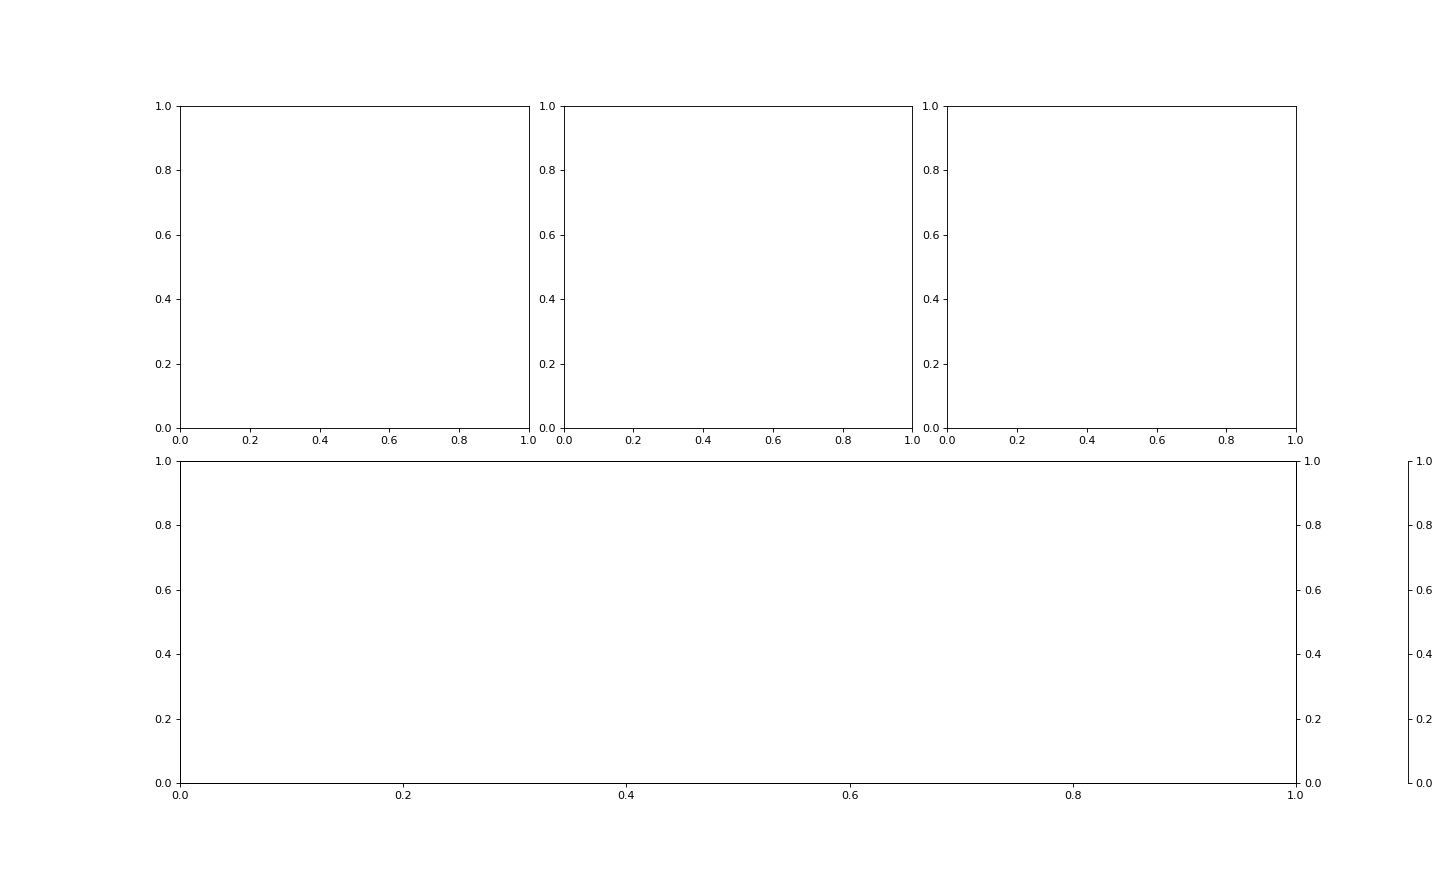

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    latitude   float64 7.5
    longitude  float64 7.5
Data variables:
    t2m        float32 292.05
<class 'xarray.core.dataset.Dataset'>
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    latitude   float64 7.5
    longitude  float64 7.5
Data variables:
    t2m        float32 297.07
<class 'xarray.core.dataset.Dataset'>
analyse called
get_tmin_tmax called
2009-04-01 00:00:00 2009-04-01 23:00:00
2009-04-02 00:00:00 2009-04-02 23:00:00
2009-04-03 00:00:00 2009-04-03 23:00:00
2009-04-04 00:00:00 2009-04-04 23:00:00
2009-04-05 00:00:00 2009-04-05 23:00:00
2009-04-06 00:00:00 2009-04-06 23:00:00
2009-04-07 00:00:00 2009-04-07 23:00:00
2009-04-08 00:00:00 2009-04-08 23:00:00
2009-04-09 00:00:00 2009-04-09 23:00:00
2009-04-10 00:00:00 2009-04-10 23:00:00
2009-04-11 00:00:00 2009-04-11 23:00:00
2009-04-12 00:00:00 2009-04-12 23:00:00
2009-04-13 00:00:00 2009-04-13 23:00:00
2009-04-14 00:00:00 2009-04-14 23:00:00
2009-04-15 00:00:00 2009-04-15 2

In [42]:
###########
# Widgets #
###########

w = Widgets()

freq = ['days', 'months']#, 'years']

lat = w.latitude()
lon = w.longitude()
button = widgets.Button(description='Get point',
                        disabled=False,
                        button_style='info',
                        tooltip='Click me to plot location data')


start = w.get_date(value=datetime.date(2009,3,1), description='Start')
end = w.get_date(value=datetime.date(2009,4,30), description='End')

dropdown_dates = widgets.Dropdown(options=times,
                                  value=times[0],
                                  description='Date selection',
                                  disabled=False)

timestep = widgets.Dropdown(options=freq,
                            value=freq[0],
                            description='Timestep',
                            disabled=False)

button.on_click(on_button_clicked)
data_list = dropdown_dates.observe(on_dropdown_dates_change, names='value')
start.observe(on_date_change)
end.observe(on_date_change)
timestep.observe(on_timestep_change)

box1 = widgets.HBox([lat, lon, button])
box2 = widgets.HBox([start, end, timestep, dropdown_dates])
box = widgets.VBox([box1, box2])

################
# Plot objects #
################

fig = plt.figure(figsize=(18, 11))

t2m_min = plt.subplot2grid((2, 3), (0, 0), colspan=1)       

t2m_mean = plt.subplot2grid((2, 3), (0, 1), colspan=1,
                                         sharex=t2m_min, sharey=t2m_min)

t2m_max = plt.subplot2grid((2, 3), (0, 2), colspan=1,
                                sharex=t2m_min, sharey=t2m_min)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plots = [t2m_min, t2m_mean, t2m_max]


ts_p = plt.subplot2grid((2, 3), (1, 0), colspan=3)
ts_p1 = ts_p.twinx()
ts_p2 = ts_p.twinx()

ts_plots = [ts_p, ts_p1, ts_p2]

ts_p2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ts_p2)
ts_p2.spines["right"].set_visible(True)

# Connect the canvas with the event
cid = fig.canvas.mpl_connect('button_press_event', on_click)

variables = ['t2m_min', 't2m_mean', 't2m_max']
colors = ['red', 'blue', 'black']
images = []

# on_dropdown_dates_change(add_colorbar=True)

display(box)